In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras


from skimage.io import imread
from skimage.transform import resize, rotate
from skimage.color import rgb2gray

from sklearn.model_selection import train_test_split

import os
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import glob

In [67]:
#Sample
input1 = keras.layers.Input(shape=(16,))
x1 = keras.layers.Dense(8, activation='relu')(input1)
input2 = keras.layers.Input(shape=(32,))
x2 = keras.layers.Dense(8, activation='relu')(input2)
subtracted = keras.layers.Subtract()([x1, x2])

out = keras.layers.Dense(4)(subtracted)
model = keras.models.Model(inputs=[input1, input2], outputs=out)
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 8)            136         input_5[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 8)            264         input_6[0][0]                    
_______________________________________________________________________________________

In [2]:
gt = pd.read_csv('public_tests/00_test_img_gt/gt.csv')
gt

,filename,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14
0,00000.jpg,51,51,127,60,169,65,203,52,68,...,193,84,156,144,92,174,140,180,168,179
1,00001.jpg,21,20,36,18,57,19,80,25,23,...,78,33,43,46,31,61,45,66,60,65
2,00002.jpg,23,116,39,83,47,57,56,19,36,...,62,31,91,86,106,122,115,100,121,81
3,00003.jpg,29,18,63,25,84,32,105,34,38,...,95,45,72,71,46,83,63,87,75,89
4,00004.jpg,31,53,76,44,107,38,136,33,40,...,129,49,111,105,72,137,106,132,126,121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,05995.jpg,22,31,41,25,80,25,100,25,30,...,97,42,69,70,47,92,58,95,75,89
5996,05996.jpg,31,37,39,37,59,28,98,17,36,...,109,34,84,70,70,104,87,106,90,104
5997,05997.jpg,21,33,41,33,83,30,100,28,47,...,119,44,86,78,55,114,75,114,94,111
5998,05998.jpg,8,13,17,10,30,10,36,10,11,...,36,15,28,25,18,36,27,35,34,34


In [3]:
def read_and_resize_dataset(dataset_dir, gt_path, size=(100, 100, 1)):
    gt = pd.read_csv(gt_path)
    files = sorted(os.listdir(dataset_dir))
    images = []
    keypoints_data = []
    for i in tqdm(range(len(files)), desc='reading images...'):
        img = imread(dataset_dir+'/'+files[i])
        x, y = img.shape[0], img.shape[1]
        img = rgb2gray(img)
        img = resize(img, size, mode='constant')

        keypoints = gt.iloc[i, 1:].values
        xs = keypoints[::2].astype('float32')
        ys = keypoints[1::2].astype('float32')
        xs = np.rint(xs / x * size[0])
        ys = np.rint(ys / y * size[1])
        keypoints[::2] = xs
        keypoints[1::2] = ys

        keypoints_data.append(keypoints)
        images.append(img)
    images = np.array(images, dtype='float32')
    keypoints_data = np.array(keypoints_data)
    return images, keypoints_data

In [4]:
x, y = read_and_resize_dataset('public_tests/00_test_img_input/train/images',
                               'public_tests/00_test_img_input/train/gt.csv')

<ipython-input-3-478588ca0c59>:9: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img = rgb2gray(img)


In [59]:
print(x.shape, y.shape)
model = keras.models.load_model('models/model1_short_36000.hdf5')
model.save('facepoints_model.hdf5')
model.summary()
y_pred = model.predict((x - np.mean(x)) / np.std(x))
np.mean((y_pred - y) ** 2)

(6000, 100, 100, 1) (6000, 28)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 100, 100, 32)      288       
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization_46 (Batc (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 50, 50, 64)        18432     
_________________________________________________________________
leaky_re_lu_47 (LeakyReLU)   (None, 50, 50, 64)        0         
_________________________________________________________________
batch_normalization_47 

3.0998529050519457

In [5]:
def mirror(img, keypoints):
    new_img = np.zeros((100, 100, 1))
    new_img[:, :, 0] = np.fliplr(img[:, :, 0])
    xs = keypoints[::2]
    xs = 100 - xs
    ys = keypoints[1::2]
    
    new_key = np.zeros_like(keypoints)
    
    new_key[0] = xs[3]
    new_key[1] = ys[3]
    
    new_key[2] = xs[2]
    new_key[3] = ys[2]
    
    new_key[4] = xs[1]
    new_key[5] = ys[1]
    
    new_key[6] = xs[0]
    new_key[7] = ys[0]
    
    new_key[8] = xs[9]
    new_key[9] = ys[9]
    
    new_key[10] = xs[8]
    new_key[11] = ys[8]
    
    new_key[12] = xs[7]
    new_key[13] = ys[7]
    
    new_key[14] = xs[6]
    new_key[15] = ys[6]
    
    new_key[16] = xs[5]
    new_key[17] = ys[5]
    
    new_key[18] = xs[4]
    new_key[19] = ys[4]
    
    new_key[20] = xs[10]
    new_key[21] = ys[10]
    
    new_key[22] = xs[13]
    new_key[23] = ys[13]
    
    new_key[24] = xs[12]
    new_key[25] = ys[12]
    
    new_key[26] = xs[11]
    new_key[27] = ys[11]
        

    return new_img, new_key

In [6]:
def rotation(image,facekeys, ang_pos):
    a=ang_pos*np.pi/180
    rot_matrix=np.array([[np.cos(a),np.sin(a)],[-np.sin(a),np.cos(a)]])
    facekeys_r=np.array(facekeys.reshape(14, 2))
    img=rotate(image,ang_pos,center=(0,0),mode='constant',resize=False,order=1)
    for i in range(0,14):

        facekeys_r[i]=np.dot(rot_matrix,facekeys_r[i].T)

    return img, facekeys_r.ravel()

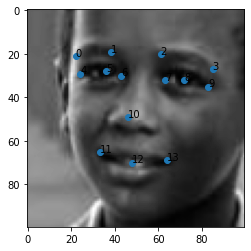

In [16]:
i = 1
img1 = x[i]
xs1 = y[i][::2]
ys1 = y[i][1::2]
plt.imshow(img1, cmap='gray')
plt.scatter(xs1, ys1)
for i in range(14):
    plt.annotate(i, (xs1[i], ys1[i]))
plt.show()

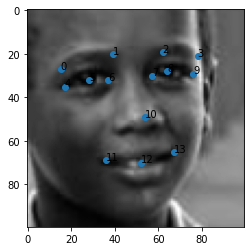

In [8]:
i = 1
img1, k1 = mirror(x[i], y[i])
xs1 = k1[::2]
ys1 = k1[1::2]
plt.imshow(img1, cmap='gray')
plt.scatter(xs1, ys1)
for i in range(14):
    plt.annotate(i, (xs1[i], ys1[i]))
plt.show()

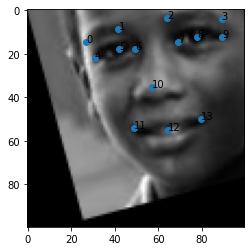

In [9]:
i = 1
img1, k1 = rotation(x[i], y[i], 15)
xs1 = k1[::2]
ys1 = k1[1::2]
plt.imshow(img1, cmap='gray')
plt.scatter(xs1, ys1)
for i in range(14):
    plt.annotate(i, (xs1[i], ys1[i]))
plt.show()

In [10]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=3213)

In [11]:
def augmentation(x, y):
    new_x, new_y = np.zeros_like(x), np.zeros_like(y)
    r = x.shape[0]
    for i in tqdm(range(r)):
        x_m, y_m = mirror(x[i], y[i])
        new_x[i] = x_m
        new_y[i] = y_m
    ex = np.vstack((x, new_x))
    ey = np.vstack((y, new_y))
    r = ex.shape[0]
    for ang in tqdm([-15, 15]):
        new_x, new_y = np.zeros((r, 100, 100, 1)), np.zeros((r, 28))

        for i in tqdm(range(r)):
            x_m, y_m = rotation(ex[i], ey[i], -15)
            new_x[i] = x_m
            new_y[i] = y_m
        ex = np.vstack((ex, new_x))
        ey = np.vstack((ey, new_y))
        print(ex.shape, ey.shape)
    return ex, ey

In [12]:
ex_train, ey_train = augmentation(x_train, y_train)
ex_val, ey_val = augmentation(x_val, y_val)


(21600, 100, 100, 1) (21600, 28)



(32400, 100, 100, 1) (32400, 28)




(2400, 100, 100, 1) (2400, 28)



(3600, 100, 100, 1) (3600, 28)



# Model 1. Kaggle

In [38]:
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D


model = Sequential()

#model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(100,100,1)))
#model.add(LeakyReLU(alpha = 0.1))
#model.add(BatchNormalization())

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(100,100,1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

#model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
#model.add(LeakyReLU(alpha = 0.1))
#model.add(BatchNormalization())

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

#model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
#model.add(LeakyReLU(alpha = 0.1))
#model.add(BatchNormalization())

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

#model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
#model.add(LeakyReLU(alpha = 0.1))
#model.add(BatchNormalization())

model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

#model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
#model.add(LeakyReLU(alpha = 0.1))
#model.add(BatchNormalization())

model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

#model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
#model.add(LeakyReLU(alpha = 0.1))
#model.add(BatchNormalization())

model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())


model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(28))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 100, 100, 32)      288       
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization_46 (Batc (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 50, 50, 64)        18432     
_________________________________________________________________
leaky_re_lu_47 (LeakyReLU)   (None, 50, 50, 64)        0         
_________________________________________________________________
batch_normalization_47 (Batc (None, 50, 50, 64)       

# Model 2. Naimish

In [55]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(32, (4,4), activation='elu', input_shape=(100,100,1)))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Conv2D(64, (3,3), activation='elu'))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Conv2D(128, (2,2), activation='elu'))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.Conv2D(256, (1,1), activation='elu'))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.4))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1000, activation='elu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1000, activation='linear'))
model.add(keras.layers.Dropout(0.6))
model.add(keras.layers.Dense(28))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 97, 97, 32)        544       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 22, 22, 128)      

# Model 3

In [41]:
model = Sequential() # Создаём модель
    
model.add(keras.layers.Conv2D(32, (3, 3), padding='valid', activation='relu', input_shape=(100, 100, 1)))
model.add(keras.layers.Conv2D(32, (3, 3), padding='valid', activation='relu'))
#model.add(BatchNormalization())
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(64, (2, 2), padding='valid', activation='relu'))
#model.add(BatchNormalization())
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(128, (2, 2), padding='valid', activation='relu'))
#model.add(BatchNormalization())
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(256, (2, 2), padding='valid', activation='relu'))
#model.add(BatchNormalization())
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Flatten()) # сплющивание в вектор чтобы вставить Dense слой

model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dropout(0.4))

model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dropout(0.4))

model.add(keras.layers.Dense(14 * 2, activation='relu')) 

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 98, 98, 32)        320       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 47, 47, 64)        8256      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 22, 22, 128)       32896     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 11, 11, 128)      

# Model 4. Github

In [36]:
model = keras.models.Sequential()
    
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(100, 100, 1)))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

model.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu'))
model.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation=tf.nn.relu))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

model.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu'))
model.add(keras.layers.Conv2D(filters=64, kernel_size=[3, 3], strides=(1, 1), padding='valid', activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

model.add(keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu'))
model.add(keras.layers.Conv2D(filters=128, kernel_size=[3, 3], strides=(1, 1), padding='valid', activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=[2, 2], strides=(1, 1), padding='valid'))

model.add(keras.layers.Conv2D(filters=256, kernel_size=[3, 3], strides=(1, 1), padding='valid', activation='relu'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=1024, activation='relu', use_bias=True))
model.add(keras.layers.Dense(units=28, activation=None, use_bias=True))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 98, 98, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 47, 47, 64)        18496     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 45, 45, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 20, 20, 64)        36928     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 18, 18, 64)       

# Model 5.

In [31]:
import keras
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.local import LocallyConnected2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import regularizers

model = Sequential()
model.add(Conv2D(20, kernel_size=(5, 5), activation='relu', 
                 input_shape=(100, 100, 1),
                 kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(40, kernel_size=(5, 5), activation='relu',
                 kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(60, kernel_size=(3, 3), activation='relu',
                 kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(LocallyConnected2D(80, (3, 3), activation='relu',
                 kernel_initializer='he_uniform'))


model.add(Flatten())


model.add(Dropout(0.25))
model.add(Dense(900, activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.25))
model.add(Dense(300, activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.25))

model.add(Dense(28, activation='relu',
                kernel_initializer='he_uniform'))

In [50]:
ex_train = (ex_train - np.mean(ex_train)) / np.std(ex_train)
ex_val = (ex_val - np.mean(ex_val)) / np.std(ex_val)

In [51]:
np.mean(ex_train), np.std(ex_train), np.mean(ex_val), np.std(ex_val)

(-1.4384192054197307e-17, 1.0, 2.3596334762664305e-17, 1.0)

In [56]:
ex_train.shape, ey_train.shape, ex_val.shape, ey_val.shape

((32400, 100, 100, 1), (32400, 28), (3600, 100, 100, 1), (3600, 28))

In [57]:
#optim = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer = 'adam', loss = 'mse')
reducelr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 5, verbose = 1)
earlystop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

In [58]:
tfhistory = model.fit(ex_train.astype('float32'), ey_train.astype('float32'), batch_size=128, shuffle=True,
                      epochs=50, validation_data=(ex_val.astype('float32'), ey_val.astype('float32')),
                      callbacks=[reducelr])

Epoch 1/100
254/254 [==============================] - 13s 51ms/step - loss: 98.5057 - val_loss: 32.9564
Epoch 2/100
254/254 [==============================] - 5s 21ms/step - loss: 41.8613 - val_loss: 37.9075
Epoch 3/100
254/254 [==============================] - 5s 21ms/step - loss: 37.0466 - val_loss: 39.4128
Epoch 4/100
254/254 [==============================] - 5s 21ms/step - loss: 34.0763 - val_loss: 25.5567
Epoch 5/100
254/254 [==============================] - 5s 21ms/step - loss: 31.6918 - val_loss: 34.9486
Epoch 6/100
254/254 [==============================] - 5s 21ms/step - loss: 29.6246 - val_loss: 21.7366
Epoch 7/100
254/254 [==============================] - 5s 21ms/step - loss: 27.9535 - val_loss: 15.7862
Epoch 8/100
254/254 [==============================] - 5s 21ms/step - loss: 26.7203 - val_loss: 14.7586
Epoch 9/100
254/254 [==============================] - 5s 21ms/step - loss: 26.0868 - val_loss: 14.3205
Epoch 10/100
254/254 [==============================] - 5s 21ms

Epoch 72/100
254/254 [==============================] - 5s 21ms/step - loss: 16.6634 - val_loss: 8.1555
Epoch 73/100
254/254 [==============================] - 5s 21ms/step - loss: 16.4277 - val_loss: 8.1205
Epoch 74/100
254/254 [==============================] - 5s 21ms/step - loss: 16.5638 - val_loss: 8.1770
Epoch 75/100
254/254 [==============================] - 5s 21ms/step - loss: 16.5906 - val_loss: 8.1524
Epoch 76/100
253/254 [============================>.] - ETA: 0s - loss: 16.6303
Epoch 00076: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
254/254 [==============================] - 6s 23ms/step - loss: 16.6301 - val_loss: 8.1019
Epoch 77/100
254/254 [==============================] - 5s 20ms/step - loss: 16.4154 - val_loss: 8.1651
Epoch 78/100
254/254 [==============================] - 5s 20ms/step - loss: 16.3673 - val_loss: 8.1195
Epoch 79/100
254/254 [==============================] - 6s 22ms/step - loss: 16.5304 - val_loss: 8.1371
Epoch 80/100
238/254 

KeyboardInterrupt: 

In [45]:
def hist_plot(history):
    plt.plot(history.history['loss'][5:])
    plt.plot(history.history['val_loss'][5:])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

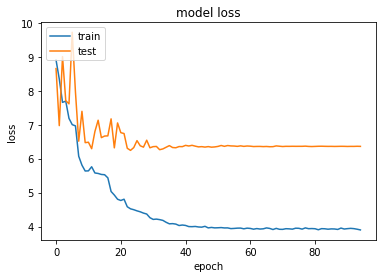

In [46]:
hist_plot(tfhistory)

In [47]:
model.save('models/model1_short_36000.hdf5')

In [64]:
model = keras.models.load_model('facepoints_model.hdf5')

ValueError: No model found in config file.